# Malware Analysis Visualization

This notebook analyzes malware data and creates visualizations for:
1. Family Distribution Analysis
2. MITRE Techniques Analysis
3. Network Behavior Analysis
4. Temporal Analysis
5. Detection and Evasion Analysis

In [171]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import json
import os

# Set up visualization style
sns.set_theme(style="whitegrid")  # This sets both matplotlib and seaborn styles consistently
plt.rcParams['figure.figsize'] = [10, 6]  # Set default figure size
plt.rcParams['axes.titlepad'] = 20  # Add padding to titles

# Function to load JSON data
def load_json_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Try to load data from various possible locations
try:
    # First try the output directory
    csv_path = Path('output/analysis_results.csv')
    if not csv_path.exists():
        csv_path = Path('output/analysis_results_updated.csv')
    
    print(f"Looking for CSV file at: {csv_path}")
    
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        print(f"✓ Successfully loaded data with {len(df)} rows")
    else:
        # If CSV not found, try loading from JSON files in hash_data
        print("CSV file not found, attempting to load from JSON files...")
        json_data = []
        json_files = list(Path('hash_data').glob('*.json'))
        
        if not json_files:
            raise FileNotFoundError("No JSON files found in hash_data directory")
            
        for json_file in json_files:
            data = load_json_data(json_file)
            if isinstance(data, list):
                json_data.extend(data)
            else:
                json_data.append(data)
        
        df = pd.DataFrame(json_data)
        print(f"✓ Successfully loaded data from {len(json_files)} JSON files with {len(df)} rows")
        
        # Save to CSV for future use
        os.makedirs('output', exist_ok=True)
        df.to_csv('output/analysis_results.csv', index=False)
        print("✓ Saved data to output/analysis_results.csv")
except Exception as e:
    print(f"⚠️ Error loading data: {str(e)}")
    print("Please ensure either:")
    print("1. Run data_collector.ipynb first to generate the analysis results, or")
    print("2. Have valid JSON files in the hash_data directory")

Looking for CSV file at: output\analysis_results.csv
✓ Successfully loaded data with 100 rows


## 1. Family Distribution Analysis

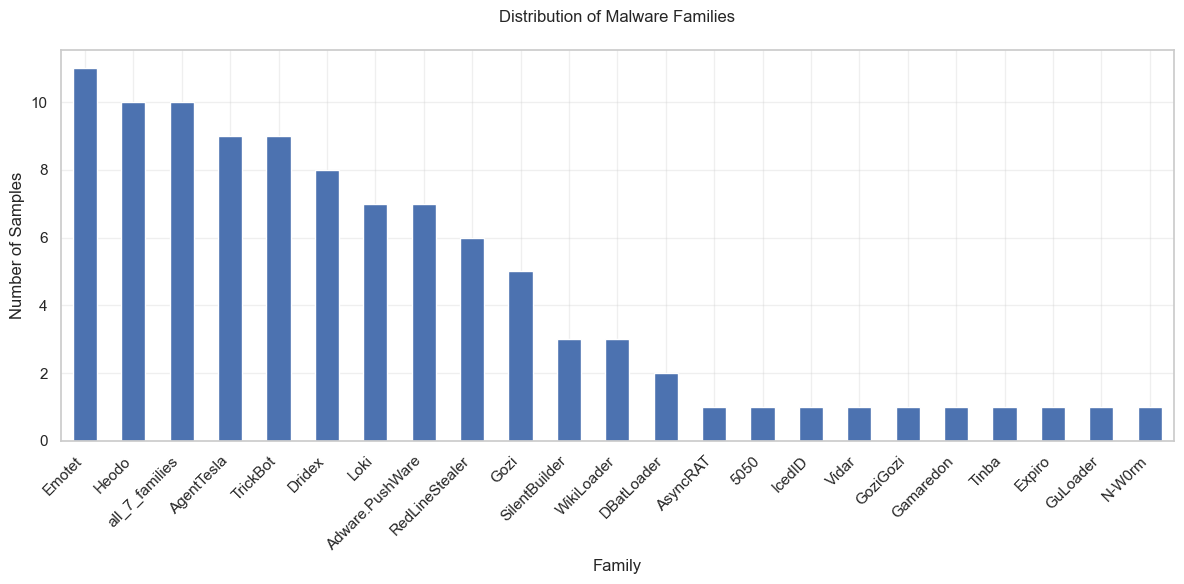


Malware Family Distribution:
Emotet: 11 samples (11.0%)
Heodo: 10 samples (10.0%)
all_7_families: 10 samples (10.0%)
AgentTesla: 9 samples (9.0%)
TrickBot: 9 samples (9.0%)
Dridex: 8 samples (8.0%)
Loki: 7 samples (7.0%)
Adware.PushWare: 7 samples (7.0%)
RedLineStealer: 6 samples (6.0%)
Gozi: 5 samples (5.0%)
SilentBuilder: 3 samples (3.0%)
WikiLoader: 3 samples (3.0%)
DBatLoader: 2 samples (2.0%)
AsyncRAT: 1 samples (1.0%)
5050: 1 samples (1.0%)
IcedID: 1 samples (1.0%)
Vidar: 1 samples (1.0%)
GoziGozi: 1 samples (1.0%)
Gamaredon: 1 samples (1.0%)
Tinba: 1 samples (1.0%)
Expiro: 1 samples (1.0%)
GuLoader: 1 samples (1.0%)
N-W0rm: 1 samples (1.0%)


In [172]:
# Family Distribution
plt.figure(figsize=(12, 6))
family_counts = df['family'].value_counts()
family_counts.plot(kind='bar')
plt.title('Distribution of Malware Families', pad=20)
plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("\nMalware Family Distribution:")
for family, count in family_counts.items():
    print(f"{family}: {count} samples ({count/len(df)*100:.1f}%)")

In [173]:
# Global Constants
# Define the path to your CSV file - check for both possible filenames
csv_path = Path('output/analysis_results.csv')
if not csv_path.exists():
    csv_path = Path('output/analysis_results_updated.csv')
    if not csv_path.exists():
        print("⚠️ Warning: CSV file not found in either location!")
        print("Please make sure to run data_collector.ipynb first to generate the analysis results.")
    
print(f"Looking for data file at: {csv_path}")
if csv_path.exists():
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)
    print(f"✓ Successfully loaded data with {len(df)} rows")

Looking for data file at: output\analysis_results.csv
✓ Successfully loaded data with 100 rows


## 2. MITRE Techniques Analysis

In [174]:
# Process MITRE techniques
if 'mitre_techniques' in df.columns:
    # Convert to list and clean
    df['mitre_list'] = df['mitre_techniques'].fillna('').astype(str).str.split(',')
    df['mitre_list'] = df['mitre_list'].apply(lambda x: [t.strip() for t in x if t.strip()])
    
    # Get overall technique distribution
    all_techniques = []
    for techs in df['mitre_list']:
        all_techniques.extend(techs)
    
    if all_techniques:
        # Plot overall distribution
        plt.figure(figsize=(12, 6))
        top_techniques = Counter(all_techniques).most_common(10)
        techniques, counts = zip(*top_techniques)
        plt.bar(techniques, counts)
        plt.title('Top 10 MITRE ATT&CK Techniques', pad=20)
        plt.xlabel('Technique ID')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Create technique distribution by family
        technique_by_family = {}
        for fam in df['family'].unique():
            fam_techniques = []
            for techs in df[df['family'] == fam]['mitre_list']:
                fam_techniques.extend(techs)
            if fam_techniques:
                technique_by_family[fam] = Counter(fam_techniques)
        
        # Create and plot heatmap
        tech_family_matrix = pd.DataFrame(0, 
                                        index=technique_by_family.keys(),
                                        columns=[t[0] for t in top_techniques])
        
        for family, techs in technique_by_family.items():
            for tech, count in techs.items():
                if tech in tech_family_matrix.columns:
                    tech_family_matrix.loc[family, tech] = count
        
        plt.figure(figsize=(15, 8))
        sns.heatmap(tech_family_matrix, cmap='YlOrRd', annot=True, fmt='g')
        plt.title('MITRE Techniques Distribution by Family', pad=20)
        plt.xlabel('Technique ID')
        plt.ylabel('Malware Family')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("\nTop 10 MITRE techniques overall:")
        for tech, count in top_techniques:
            print(f"{tech}: {count} occurrences ({count/len(all_techniques)*100:.1f}%)")
else:
    print("No MITRE techniques data available")

## 3. Network Behavior Analysis

<Figure size 1200x600 with 0 Axes>

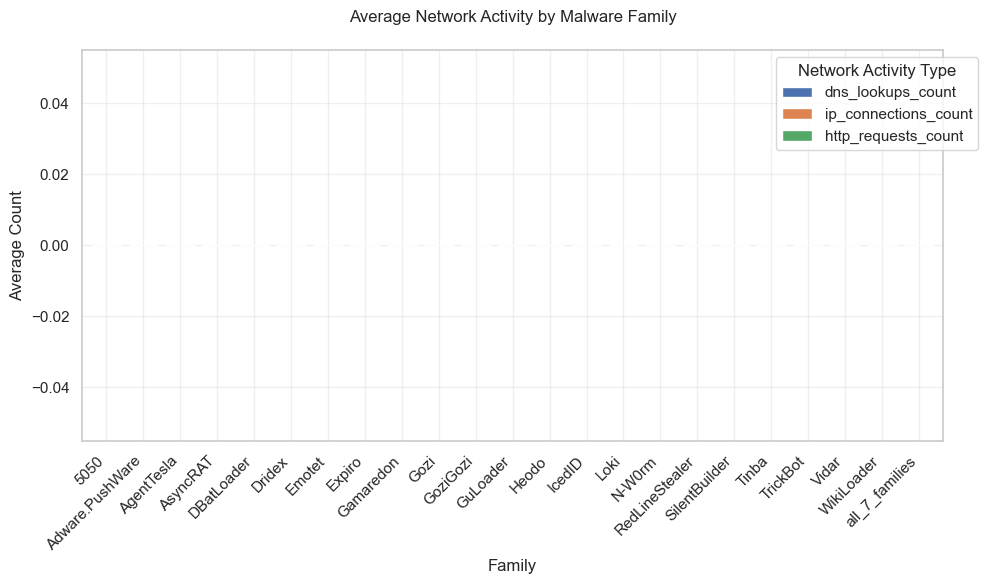

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


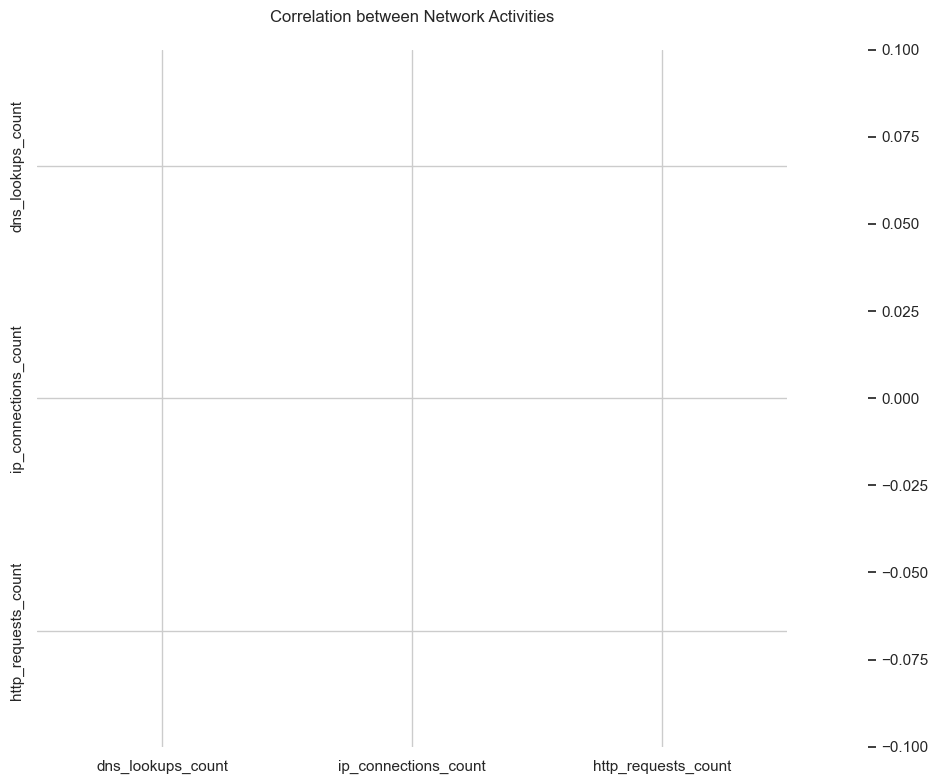


Network Activity Statistics by Family:

Gozi:
  dns_lookups_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  ip_connections_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  http_requests_count:
    Average: 0.00
    Maximum: 0
    Total: 0

Loki:
  dns_lookups_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  ip_connections_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  http_requests_count:
    Average: 0.00
    Maximum: 0
    Total: 0

Dridex:
  dns_lookups_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  ip_connections_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  http_requests_count:
    Average: 0.00
    Maximum: 0
    Total: 0

AgentTesla:
  dns_lookups_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  ip_connections_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  http_requests_count:
    Average: 0.00
    Maximum: 0
    Total: 0

TrickBot:
  dns_lookups_count:
    Average: 0.00
    Maximum: 0
    Total: 0
  ip_connections_count

In [175]:
# Network behavior analysis
network_cols = ['dns_lookups_count', 'ip_connections_count', 'http_requests_count']

if all(col in df.columns for col in network_cols):
    # Calculate average network activity by family
    network_profile = df.groupby('family')[network_cols].agg(['mean', 'max'])
    
    # Plot average network activity
    plt.figure(figsize=(12, 6))
    network_means = df.groupby('family')[network_cols].mean()
    network_means.plot(kind='bar', width=0.8)
    plt.title('Average Network Activity by Malware Family', pad=20)
    plt.xlabel('Family')
    plt.ylabel('Average Count')
    plt.legend(title='Network Activity Type', bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    correlation = df[network_cols].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation between Network Activities', pad=20)
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nNetwork Activity Statistics by Family:")
    for family in df['family'].unique():
        print(f"\n{family}:")
        for col in network_cols:
            data = df[df['family'] == family][col]
            print(f"  {col}:")
            print(f"    Average: {data.mean():.2f}")
            print(f"    Maximum: {data.max():.0f}")
            print(f"    Total: {data.sum():.0f}")
else:
    print("Network behavior columns not found in the dataset")

## 4. Detection and Evasion Analysis

In [176]:
# Detection and Evasion Analysis
evasion_cols = ['anti_vm', 'anti_debug', 'code_injection', 'encryption', 'obfuscation']

if any(col in df.columns for col in evasion_cols):
    # Get available evasion columns
    available_evasion = [col for col in evasion_cols if col in df.columns]
    
    # Create evasion techniques heatmap
    plt.figure(figsize=(12, 6))
    evasion_by_family = df.groupby('family')[available_evasion].mean()
    sns.heatmap(evasion_by_family, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('Evasion Techniques by Malware Family', pad=20)
    plt.xlabel('Evasion Technique')
    plt.ylabel('Malware Family')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot overall evasion technique usage
    plt.figure(figsize=(10, 6))
    evasion_totals = df[available_evasion].sum().sort_values(ascending=False)
    evasion_totals.plot(kind='bar')
    plt.title('Overall Usage of Evasion Techniques', pad=20)
    plt.xlabel('Technique')
    plt.ylabel('Number of Samples')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nEvasion Technique Statistics:")
    for col in available_evasion:
        count = df[col].sum()
        pct = (count / len(df)) * 100
        print(f"{col}: {count} samples ({pct:.1f}%)")
else:
    print("No evasion technique data available in the dataset")

No evasion technique data available in the dataset


In [177]:
# Display basic information and first few rows
# print(df.info())
df.head(3)

,hash,family,source,status,detection_ratio,first_seen,last_seen,processes_count,files_written_count,files_deleted_count,registry_keys_set_count,dns_lookups_count,ip_connections_count,http_requests_count,mutexes_count,mitre_techniques_count,mitre_techniques,collected_date,mitre_list
0,818c482b0d6be6f5c9449c76d79edf4e038fe639267b2d...,Gozi,JAMESWT_WT,success,16/78,1696549101,1721357023,0,0,0,0,0,0,0,0,0,NaN,2025-11-04T03:17:56.679772+00:00,[]
1,68bd5e4a0955b5d2b89751532443e0c42ae2974d6fe900...,Loki,threatcat_ch,success,58/76,1746174671,1756451219,0,0,0,0,0,0,0,0,0,NaN,2025-11-04T03:18:29.309932+00:00,[]
2,68d60ea2de32a82a0e8675af68237a5184bd242ea3dc25...,Dridex,SecuriteInfoCom,success,49/76,1640185375,1741669328,0,0,0,0,0,0,0,0,0,NaN,2025-11-04T03:19:02.200305+00:00,[]


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hash                     100 non-null    object 
 1   family                   100 non-null    object 
 2   source                   100 non-null    object 
 3   status                   100 non-null    object 
 4   detection_ratio          100 non-null    object 
 5   first_seen               100 non-null    int64  
 6   last_seen                100 non-null    int64  
 7   processes_count          100 non-null    int64  
 8   files_written_count      100 non-null    int64  
 9   files_deleted_count      100 non-null    int64  
 10  registry_keys_set_count  100 non-null    int64  
 11  dns_lookups_count        100 non-null    int64  
 12  ip_connections_count     100 non-null    int64  
 13  http_requests_count      100 non-null    int64  
 14  mutexes_count            10

In [179]:
df.isnull().sum()

hash                         0
family                       0
source                       0
status                       0
detection_ratio              0
first_seen                   0
last_seen                    0
processes_count              0
files_written_count          0
files_deleted_count          0
registry_keys_set_count      0
dns_lookups_count            0
ip_connections_count         0
http_requests_count          0
mutexes_count                0
mitre_techniques_count       0
mitre_techniques           100
collected_date               0
mitre_list                   0
dtype: int64

In [180]:
# Check DataFrame structure
print("DataFrame Columns:")
print(df.columns.tolist())
print("\nSample row:")
print(df.iloc[0])

DataFrame Columns:
['hash', 'family', 'source', 'status', 'detection_ratio', 'first_seen', 'last_seen', 'processes_count', 'files_written_count', 'files_deleted_count', 'registry_keys_set_count', 'dns_lookups_count', 'ip_connections_count', 'http_requests_count', 'mutexes_count', 'mitre_techniques_count', 'mitre_techniques', 'collected_date', 'mitre_list']

Sample row:
hash                       818c482b0d6be6f5c9449c76d79edf4e038fe639267b2d...
family                                                                  Gozi
source                                                            JAMESWT_WT
status                                                               success
detection_ratio                                                        16/78
first_seen                                                        1696549101
last_seen                                                         1721357023
processes_count                                                            0
files_writte

In [181]:
# Data Preprocessing
print("Data Preprocessing Steps:")

# 1. Clean up column names
df.columns = df.columns.str.strip().str.lower()
print("1. Cleaned column names")

# 2. Fill missing values appropriately
numeric_columns = ['processes_count', 'files_written_count', 'registry_keys_set_count', 
                  'dns_lookups_count', 'ip_connections_count', 'http_requests_count']

# Create columns if they don't exist
for col in numeric_columns:
    if col not in df.columns:
        df[col] = 0
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

print("2. Handled numeric columns")

# 3. Handle detection ratio
if 'detection_ratio' in df.columns:
    # Ensure detection ratio is in correct format (num/num)
    df['detection_ratio'] = df['detection_ratio'].fillna('0/1')
    print("3. Processed detection ratios")
else:
    print("⚠️ Warning: detection_ratio column not found")

# 4. Process MITRE techniques
if 'mitre_techniques' in df.columns:
    df['mitre_techniques'] = df['mitre_techniques'].fillna('')
    print("4. Processed MITRE techniques")
else:
    print("⚠️ Warning: mitre_techniques column not found")

# 5. Convert timestamps
if 'first_seen' in df.columns:
    df['first_seen'] = pd.to_datetime(df['first_seen'], errors='coerce')
    print("5. Converted timestamps")
else:
    print("⚠️ Warning: first_seen column not found")

print("\nDataFrame Info:")
print(df.info())

Data Preprocessing Steps:
1. Cleaned column names
2. Handled numeric columns
3. Processed detection ratios
4. Processed MITRE techniques
5. Converted timestamps

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   hash                     100 non-null    object        
 1   family                   100 non-null    object        
 2   source                   100 non-null    object        
 3   status                   100 non-null    object        
 4   detection_ratio          100 non-null    object        
 5   first_seen               100 non-null    datetime64[ns]
 6   last_seen                100 non-null    int64         
 7   processes_count          100 non-null    int64         
 8   files_written_count      100 non-null    int64         
 9   files_deleted_count      100 non-null    i

# Malware Analysis Visualizations

Let's create several visualizations to understand:
1. Distribution of malware families
2. Behavioral patterns across families
3. MITRE ATT&CK technique usage
4. Network activity patterns
5. Detection ratios

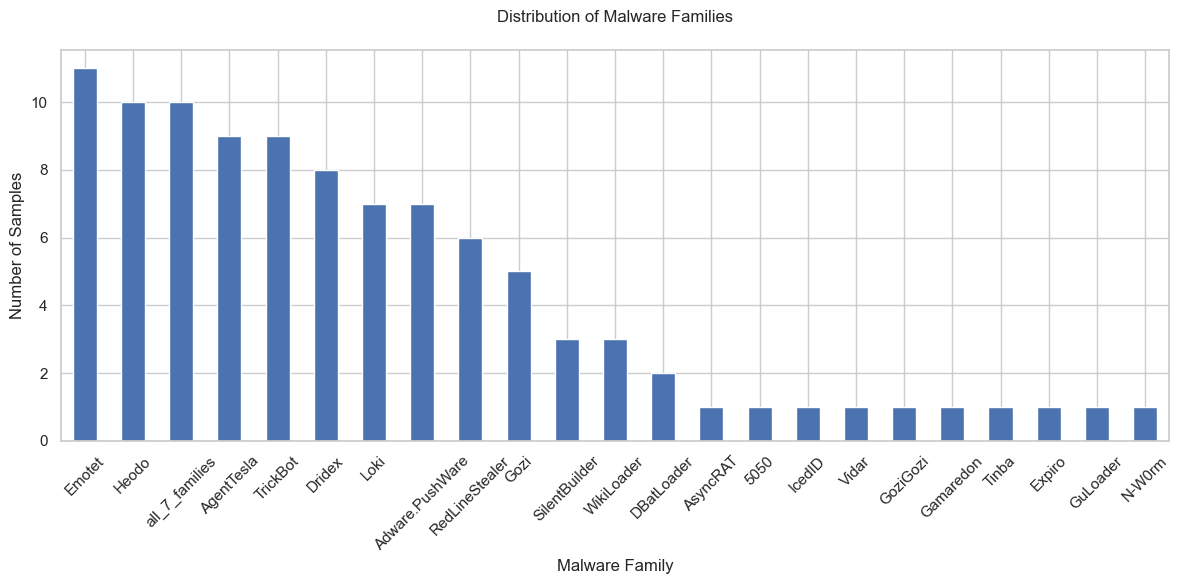


Malware Family Distribution:
Emotet: 11 samples
Heodo: 10 samples
all_7_families: 10 samples
AgentTesla: 9 samples
TrickBot: 9 samples
Dridex: 8 samples
Loki: 7 samples
Adware.PushWare: 7 samples
RedLineStealer: 6 samples
Gozi: 5 samples
SilentBuilder: 3 samples
WikiLoader: 3 samples
DBatLoader: 2 samples
AsyncRAT: 1 samples
5050: 1 samples
IcedID: 1 samples
Vidar: 1 samples
GoziGozi: 1 samples
Gamaredon: 1 samples
Tinba: 1 samples
Expiro: 1 samples
GuLoader: 1 samples
N-W0rm: 1 samples


In [182]:
# 1. Distribution of Malware Families
plt.figure(figsize=(12, 6))
family_counts = df['family'].value_counts()
family_counts.plot(kind='bar')
plt.title('Distribution of Malware Families')
plt.xlabel('Malware Family')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print exact counts
print("\nMalware Family Distribution:")
for family, count in family_counts.items():
    print(f"{family}: {count} samples")

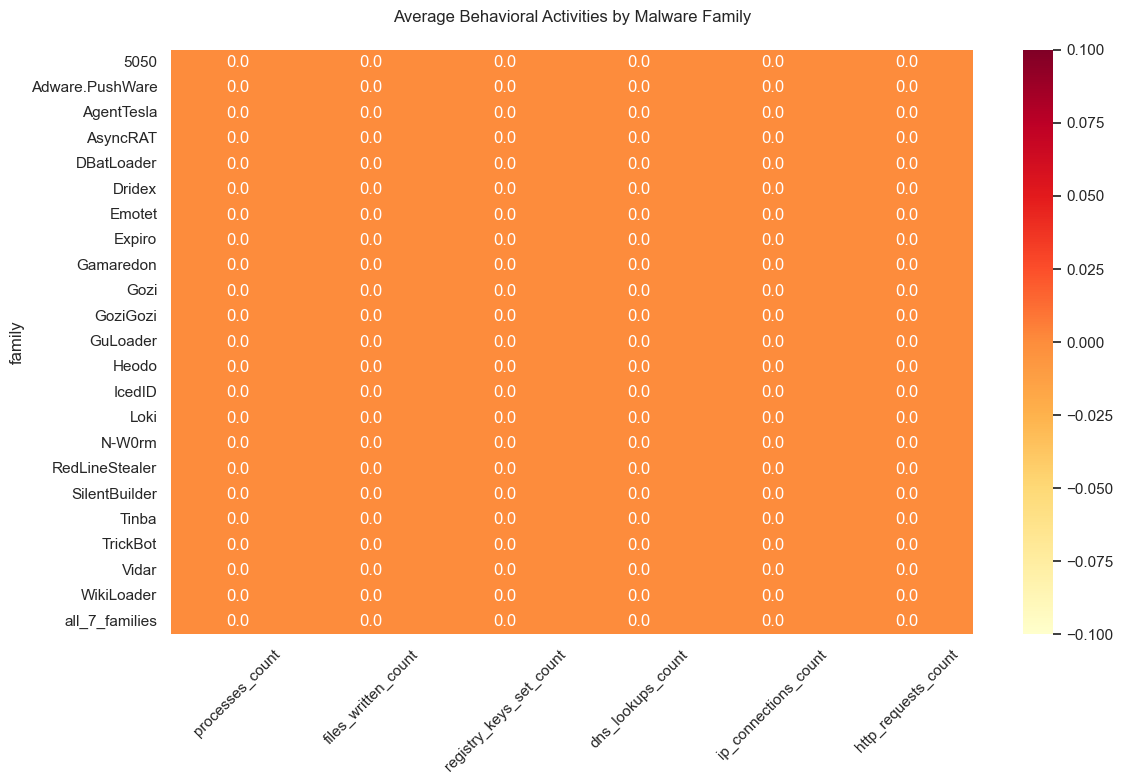


Behavioral Statistics by Family:
                 processes_count  files_written_count  \
family                                                  
5050                         0.0                  0.0   
Adware.PushWare              0.0                  0.0   
AgentTesla                   0.0                  0.0   
AsyncRAT                     0.0                  0.0   
DBatLoader                   0.0                  0.0   
Dridex                       0.0                  0.0   
Emotet                       0.0                  0.0   
Expiro                       0.0                  0.0   
Gamaredon                    0.0                  0.0   
Gozi                         0.0                  0.0   
GoziGozi                     0.0                  0.0   
GuLoader                     0.0                  0.0   
Heodo                        0.0                  0.0   
IcedID                       0.0                  0.0   
Loki                         0.0                  0.0 

In [183]:
# 2. Behavioral Activity Analysis

# Convert counts to numeric and replace any errors with 0
behaviors = ['processes_count', 'files_written_count', 'registry_keys_set_count', 
            'dns_lookups_count', 'ip_connections_count', 'http_requests_count']

# First check if these columns exist
missing_cols = [col for col in behaviors if col not in df.columns]
if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
    print("\nAvailable columns:")
    print(df.columns.tolist())
else:
    # Convert counts to numeric, replacing errors with 0
    for col in behaviors:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Calculate average behaviors by family
    behavior_by_family = df.groupby('family')[behaviors].mean()

    # Create heatmap
    plt.figure(figsize=(12, 8))
    import seaborn as sns
    sns.heatmap(behavior_by_family, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Average Behavioral Activities by Malware Family')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nBehavioral Statistics by Family:")
    print(behavior_by_family.round(2))

In [184]:
# 3. MITRE ATT&CK Technique Analysis

if 'mitre_techniques' not in df.columns:
    print("Warning: 'mitre_techniques' column not found in dataset")
else:
    # Split MITRE techniques string into list and count unique techniques
    df['mitre_list'] = df['mitre_techniques'].str.split(', ')
    all_techniques = [tech for techs in df['mitre_list'].dropna() for tech in techs if tech]

    if not all_techniques:
        print("No MITRE techniques found in the dataset")
    else:
        from collections import Counter
        technique_counts = Counter(all_techniques)

        # Plot top 10 MITRE techniques
        plt.figure(figsize=(12, 6))
        top_techniques = dict(sorted(technique_counts.items(), key=lambda x: x[1], reverse=True)[:10])
        plt.bar(top_techniques.keys(), top_techniques.values())
        plt.title('Top 10 MITRE ATT&CK Techniques Used')
        plt.xlabel('Technique ID')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print detailed statistics
        print("\nTop 10 MITRE ATT&CK Techniques:")
        for technique, count in top_techniques.items():
            print(f"{technique}: {count} occurrences")

No MITRE techniques found in the dataset


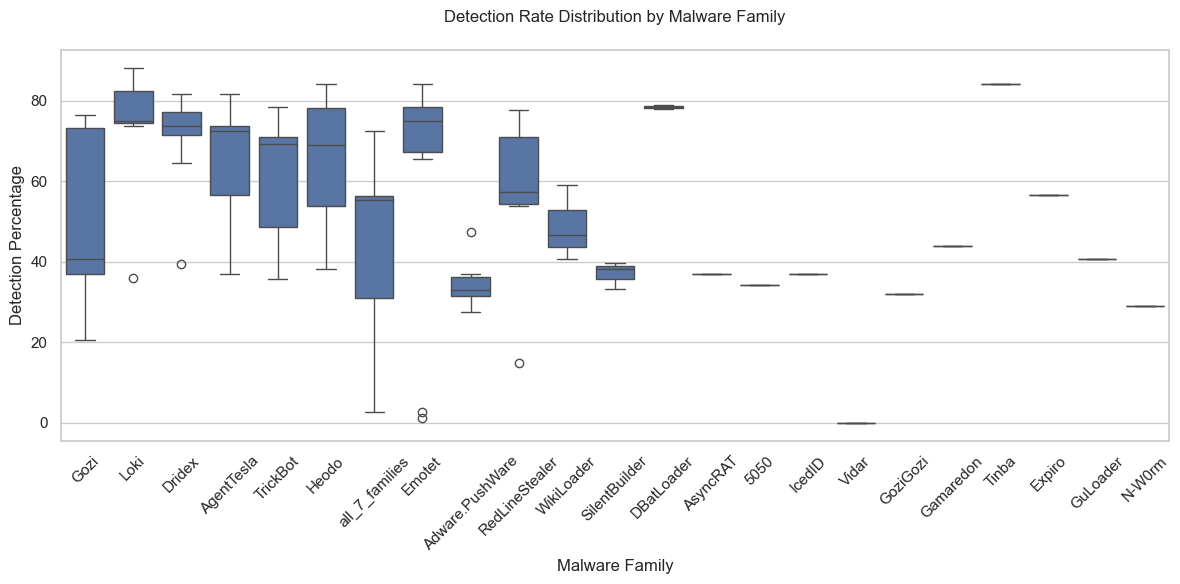


Detection Rate Statistics by Family:
                  mean    min    max    std
family                                     
5050             34.21  34.21  34.21    NaN
Adware.PushWare  34.77  27.63  47.37   6.30
AgentTesla       64.18  36.84  81.58  16.02
AsyncRAT         36.84  36.84  36.84    NaN
DBatLoader       78.44  77.92  78.95   0.73
Dridex           70.26  39.47  81.58  13.43
Emotet           62.09   1.32  84.21  30.18
Expiro           56.58  56.58  56.58    NaN
Gamaredon        44.00  44.00  44.00    NaN
Gozi             49.51  20.51  76.32  24.25
GoziGozi         32.05  32.05  32.05    NaN
GuLoader         40.79  40.79  40.79    NaN
Heodo            64.44  38.16  84.21  16.43
IcedID           36.84  36.84  36.84    NaN
Loki             73.19  36.00  88.16  17.55
N-W0rm           28.95  28.95  28.95    NaN
RedLineStealer   55.99  14.86  77.63  22.52
SilentBuilder    37.07  33.33  39.73   3.34
Tinba            84.21  84.21  84.21    NaN
TrickBot         61.92  35.80  78.38  

In [185]:
# 4. Detection Ratio Analysis

if 'detection_ratio' not in df.columns:
    print("Warning: 'detection_ratio' column not found in dataset")
else:
    try:
        # Extract numerator and denominator from detection ratio strings
        df[['detected', 'total']] = df['detection_ratio'].str.split('/', expand=True).astype(float)
        df['detection_percentage'] = (df['detected'] / df['total'] * 100).round(2)

        # Create box plot of detection percentages by family
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='family', y='detection_percentage', data=df)
        plt.title('Detection Rate Distribution by Malware Family')
        plt.xlabel('Malware Family')
        plt.ylabel('Detection Percentage')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nDetection Rate Statistics by Family:")
        stats = df.groupby('family')['detection_percentage'].agg(['mean', 'min', 'max', 'std']).round(2)
        print(stats)
    except Exception as e:
        print(f"Error processing detection ratios: {str(e)}")
        print("\nSample of detection_ratio values:")
        print(df['detection_ratio'].head())

<Figure size 1500x600 with 0 Axes>

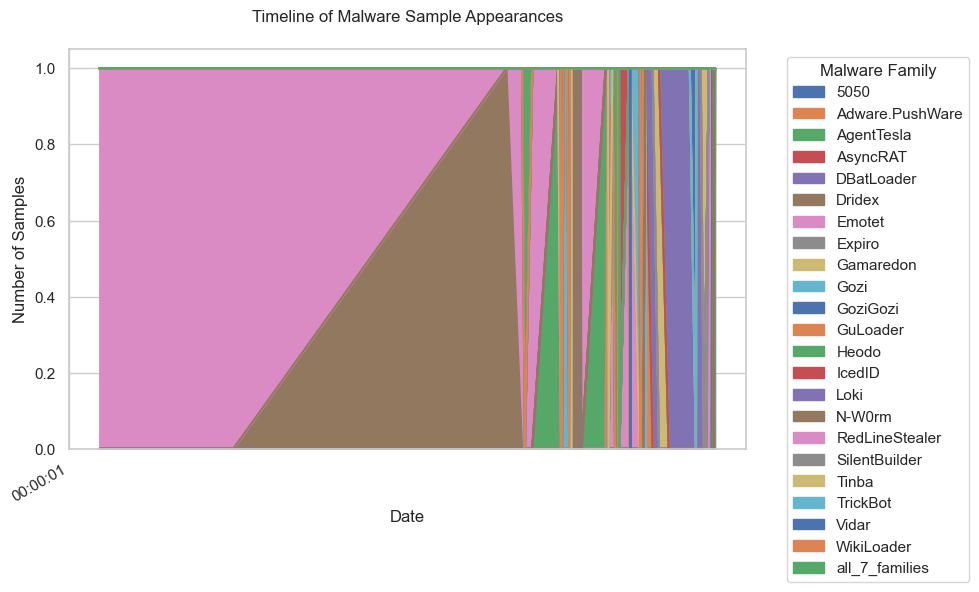


Monthly Sample Counts by Family:
family      5050  Adware.PushWare  AgentTesla  AsyncRAT  DBatLoader  Dridex  \
first_seen                                                                    
1970-01        1                7           9         1           2       8   

family      Emotet  Expiro  Gamaredon  Gozi  ...  IcedID  Loki  N-W0rm  \
first_seen                                   ...                         
1970-01         11       1          1     5  ...       1     7       1   

family      RedLineStealer  SilentBuilder  Tinba  TrickBot  Vidar  WikiLoader  \
first_seen                                                                      
1970-01                  6              3      1         9      1           3   

family      all_7_families  
first_seen                  
1970-01                 10  

[1 rows x 23 columns]


In [186]:
# 5. Time-based Analysis

if 'first_seen' not in df.columns:
    print("Warning: 'first_seen' column not found in dataset")
else:
    try:
        # Convert timestamps to datetime
        df['first_seen'] = pd.to_datetime(df['first_seen'])

        # Create timeline of sample appearances
        plt.figure(figsize=(15, 6))
        timeline = df.groupby(['family', 'first_seen']).size().unstack(level=0).fillna(0)
        timeline.plot(kind='area', stacked=True)
        plt.title('Timeline of Malware Sample Appearances')
        plt.xlabel('Date')
        plt.ylabel('Number of Samples')
        plt.legend(title='Malware Family', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Print monthly statistics
        print("\nMonthly Sample Counts by Family:")
        monthly_stats = df.groupby([df['first_seen'].dt.strftime('%Y-%m'), 'family']).size().unstack(fill_value=0)
        print(monthly_stats)
    except Exception as e:
        print(f"Error processing timestamps: {str(e)}")
        print("\nSample of first_seen values:")
        print(df['first_seen'].head())

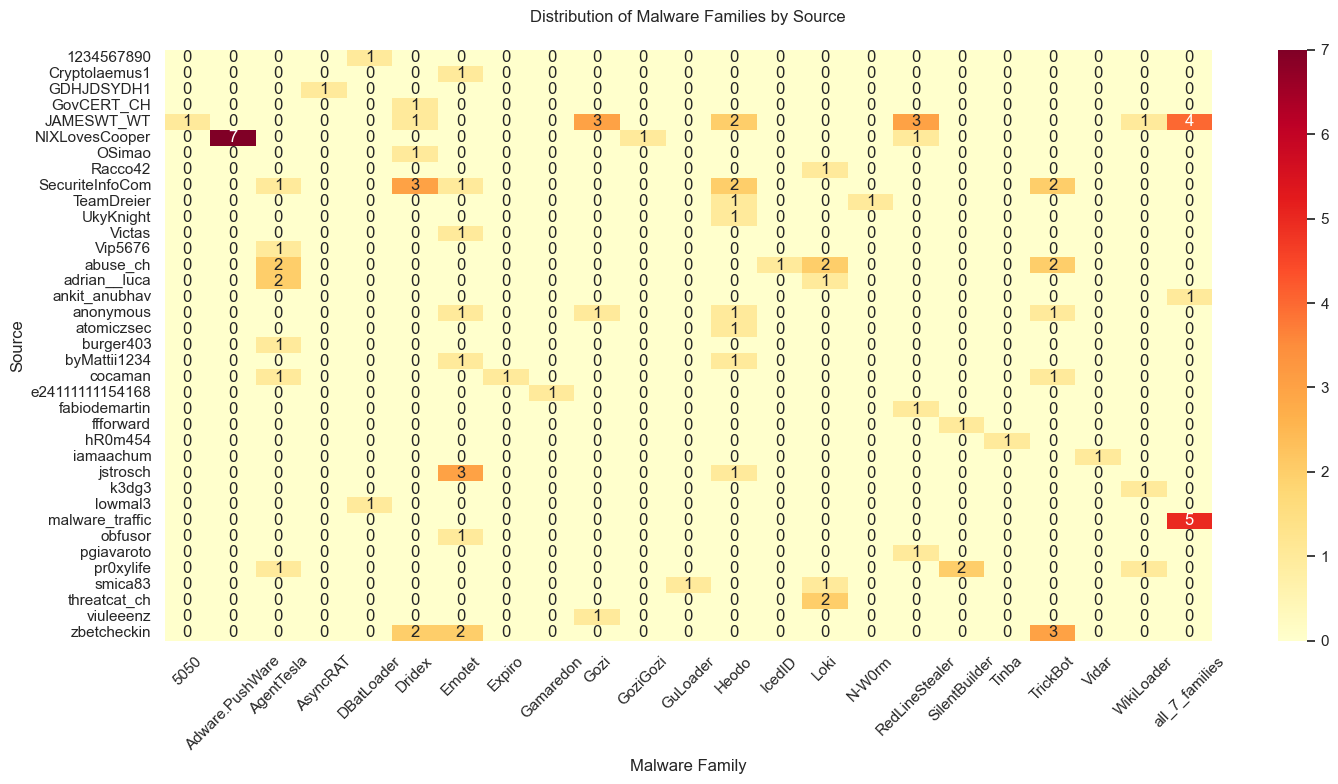


Top Sources by Number of Samples:
source
JAMESWT_WT         15
SecuriteInfoCom     9
NIXLovesCooper      9
abuse_ch            7
zbetcheckin         7
malware_traffic     5
pr0xylife           4
jstrosch            4
anonymous           4
adrian__luca        3
Name: count, dtype: int64


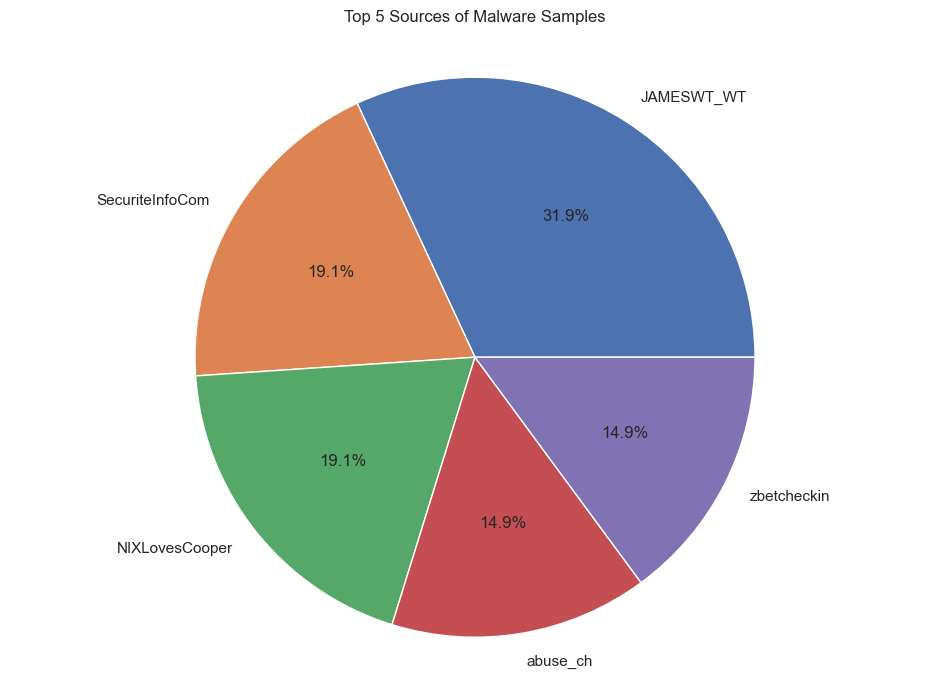

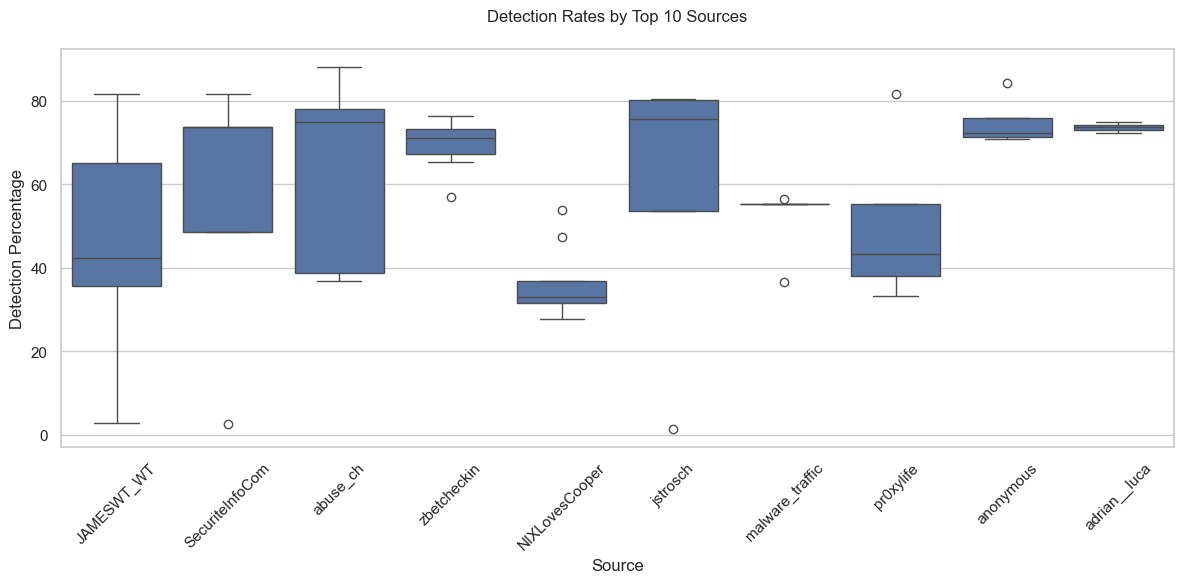

In [187]:
# 6. Source Analysis

# Create a heatmap of sources vs malware families
plt.figure(figsize=(15, 8))
source_family_matrix = pd.crosstab(df['source'], df['family'])
sns.heatmap(source_family_matrix, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Distribution of Malware Families by Source')
plt.xlabel('Malware Family')
plt.ylabel('Source')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print top sources
print("\nTop Sources by Number of Samples:")
source_counts = df['source'].value_counts()
print(source_counts.head(10))

# Create a pie chart of top sources
plt.figure(figsize=(12, 8))
plt.pie(source_counts.head(5), labels=source_counts.head(5).index, autopct='%1.1f%%')
plt.title('Top 5 Sources of Malware Samples')
plt.axis('equal')
plt.show()

# Create bar plot of detection rates by source
if 'detection_percentage' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='source', y='detection_percentage', data=df.loc[df['source'].isin(source_counts.head(10).index)])
    plt.title('Detection Rates by Top 10 Sources')
    plt.xlabel('Source')
    plt.ylabel('Detection Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


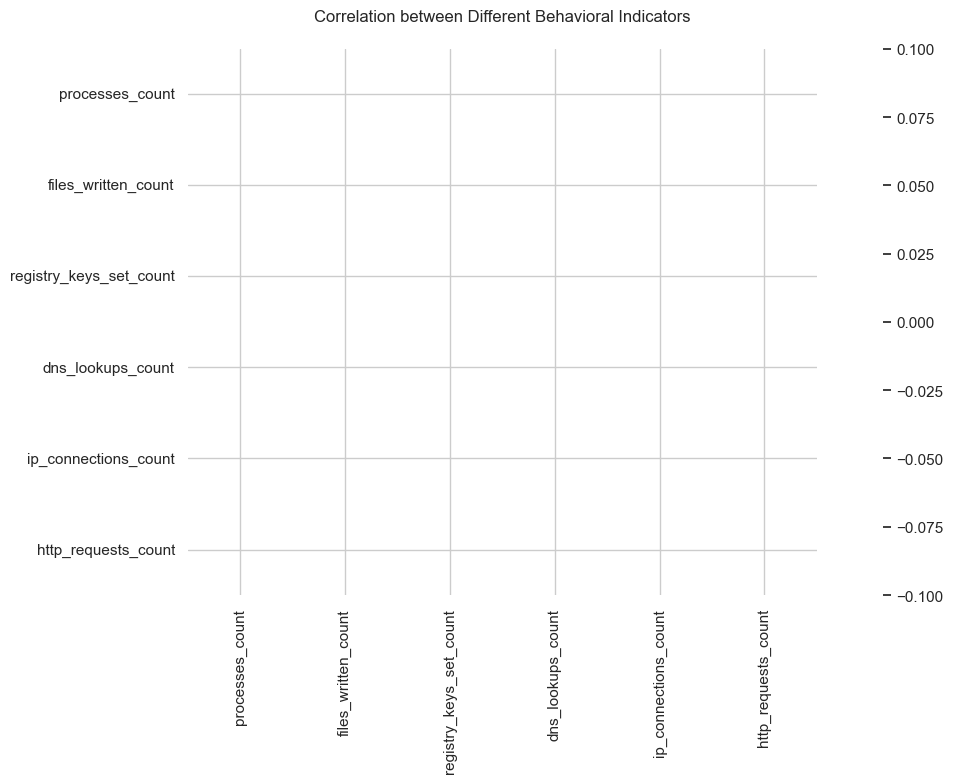

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:115: RuntimeWarning: invalid value encountered in divide
  adj = (locs - lim1[0]) / (lim1[1] - l

<Figure size 1500x1500 with 0 Axes>

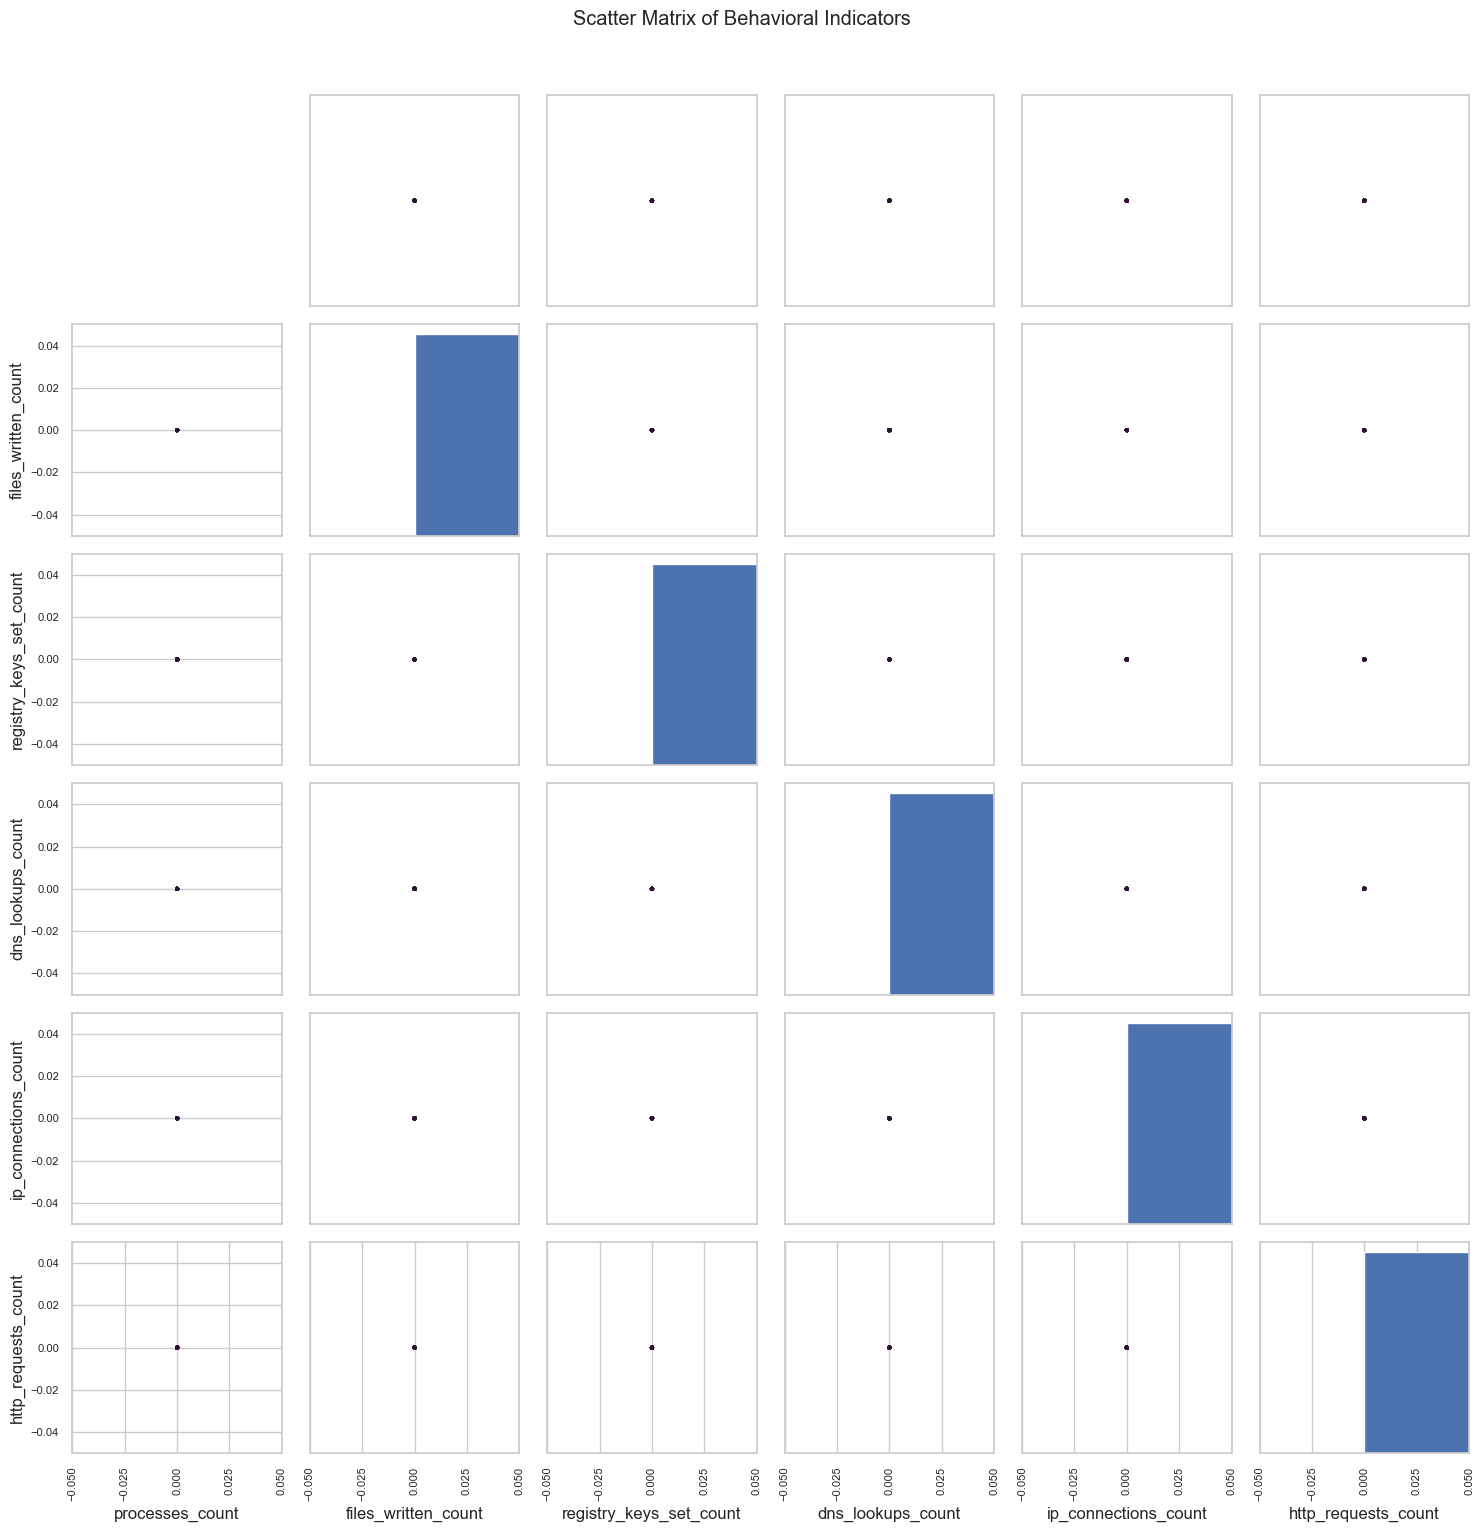


Behavioral Statistics by Family:
                processes_count          files_written_count           \
                           mean  std max                mean  std max   
family                                                                  
5050                        0.0  NaN   0                 0.0  NaN   0   
Adware.PushWare             0.0  0.0   0                 0.0  0.0   0   
AgentTesla                  0.0  0.0   0                 0.0  0.0   0   
AsyncRAT                    0.0  NaN   0                 0.0  NaN   0   
DBatLoader                  0.0  0.0   0                 0.0  0.0   0   
Dridex                      0.0  0.0   0                 0.0  0.0   0   
Emotet                      0.0  0.0   0                 0.0  0.0   0   
Expiro                      0.0  NaN   0                 0.0  NaN   0   
Gamaredon                   0.0  NaN   0                 0.0  NaN   0   
Gozi                        0.0  0.0   0                 0.0  0.0   0   
GoziGozi         

In [188]:
# 7. Advanced Behavioral Analysis

# Create correlation matrix of behavioral indicators
behavioral_cols = ['processes_count', 'files_written_count', 'registry_keys_set_count', 
                  'dns_lookups_count', 'ip_connections_count', 'http_requests_count']

plt.figure(figsize=(10, 8))
correlation_matrix = df[behavioral_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Different Behavioral Indicators')
plt.tight_layout()
plt.show()

# Create scatter plot matrix for behavioral indicators by family
plt.figure(figsize=(15, 15))
behavior_data = df[['family'] + behavioral_cols]
scatter_matrix = pd.plotting.scatter_matrix(behavior_data.drop('family', axis=1), 
                                          c=pd.factorize(df['family'])[0],
                                          figsize=(15, 15), alpha=0.5)
plt.suptitle('Scatter Matrix of Behavioral Indicators', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics by family
print("\nBehavioral Statistics by Family:")
behavior_stats = df.groupby('family')[behavioral_cols].agg(['mean', 'std', 'max'])
print(behavior_stats.round(2))

<Figure size 1200x600 with 0 Axes>

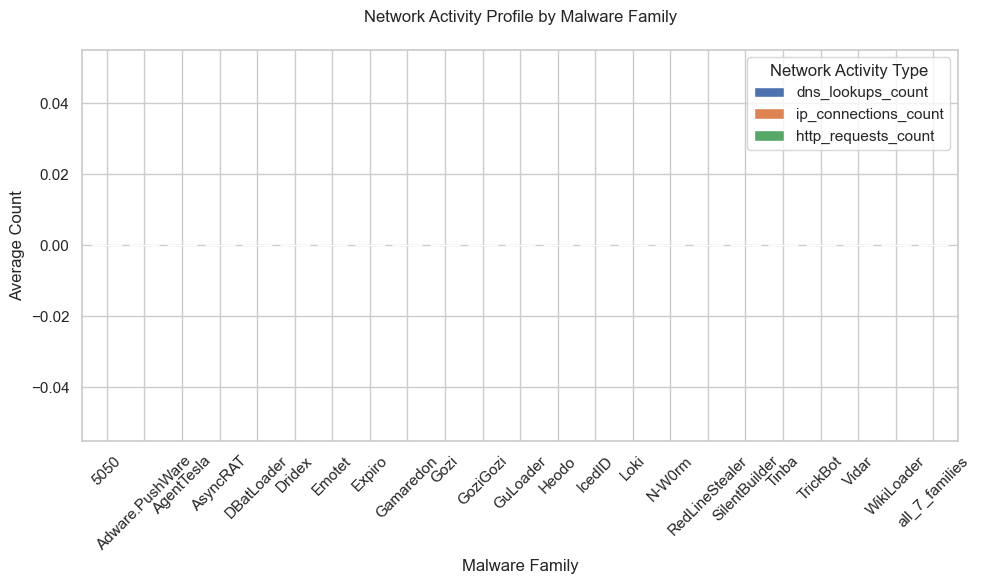


Network Activity Statistics by Family:
                dns_lookups_count     ip_connections_count      \
                             mean max                 mean max   
family                                                           
5050                          0.0   0                  0.0   0   
Adware.PushWare               0.0   0                  0.0   0   
AgentTesla                    0.0   0                  0.0   0   
AsyncRAT                      0.0   0                  0.0   0   
DBatLoader                    0.0   0                  0.0   0   
Dridex                        0.0   0                  0.0   0   
Emotet                        0.0   0                  0.0   0   
Expiro                        0.0   0                  0.0   0   
Gamaredon                     0.0   0                  0.0   0   
Gozi                          0.0   0                  0.0   0   
GoziGozi                      0.0   0                  0.0   0   
GuLoader                      0.0   

In [189]:
# 8. File Type Analysis and Network Behavior

# Analyze file types
if 'file_type' in df.columns:
    plt.figure(figsize=(12, 6))
    file_type_counts = df['file_type'].value_counts()
    file_type_counts.plot(kind='bar')
    plt.title('Distribution of Malware File Types')
    plt.xlabel('File Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Create heatmap of file types vs families
    plt.figure(figsize=(12, 8))
    type_family_matrix = pd.crosstab(df['file_type'], df['family'])
    sns.heatmap(type_family_matrix, cmap='YlOrRd', annot=True, fmt='d')
    plt.title('Distribution of File Types across Malware Families')
    plt.xlabel('Malware Family')
    plt.ylabel('File Type')
    plt.tight_layout()
    plt.show()

# Network behavior analysis
network_cols = ['dns_lookups_count', 'ip_connections_count', 'http_requests_count']
if all(col in df.columns for col in network_cols):
    # Create network activity profile by family
    plt.figure(figsize=(12, 6))
    network_profile = df.groupby('family')[network_cols].mean()
    network_profile.plot(kind='bar', width=0.8)
    plt.title('Network Activity Profile by Malware Family')
    plt.xlabel('Malware Family')
    plt.ylabel('Average Count')
    plt.legend(title='Network Activity Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print detailed network statistics
    print("\nNetwork Activity Statistics by Family:")
    network_stats = df.groupby('family')[network_cols].agg(['mean', 'max'])
    print(network_stats.round(2))

In [190]:
# 9. Temporal Analysis and Persistence Patterns

# Check for temporal columns
temporal_cols = ['first_seen', 'last_seen', 'active_days']
if all(col in df.columns for col in temporal_cols):
    # Convert date columns to datetime if needed
    for col in ['first_seen', 'last_seen']:
        if df[col].dtype != 'datetime64[ns]':
            df[col] = pd.to_datetime(df[col])
    
    # Plot malware persistence over time
    plt.figure(figsize=(12, 6))
    persistence_by_family = df.groupby('family')['active_days'].agg(['mean', 'max'])
    persistence_by_family.plot(kind='bar')
    plt.title('Malware Persistence by Family')
    plt.xlabel('Malware Family')
    plt.ylabel('Days')
    plt.legend(['Average Active Days', 'Maximum Active Days'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Create timeline of first appearances
    plt.figure(figsize=(12, 6))
    first_seen_counts = df.groupby([df['first_seen'].dt.to_period('M'), 'family']).size().unstack()
    first_seen_counts.plot(kind='area', stacked=True)
    plt.title('Timeline of Malware Family Appearances')
    plt.xlabel('Month')
    plt.ylabel('Number of New Samples')
    plt.legend(title='Malware Family', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Analyze persistence mechanisms if available
persistence_mechanisms = ['registry_persistence', 'startup_persistence', 'service_persistence']
if any(col in df.columns for col in persistence_mechanisms):
    available_mechanisms = [col for col in persistence_mechanisms if col in df.columns]
    
    plt.figure(figsize=(10, 6))
    persistence_data = df[available_mechanisms].sum()
    persistence_data.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribution of Persistence Mechanisms')
    plt.axis('equal')
    plt.show()

    # Create heatmap of persistence mechanisms by family
    plt.figure(figsize=(12, 6))
    persistence_by_family = df.groupby('family')[available_mechanisms].mean()
    sns.heatmap(persistence_by_family, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('Persistence Mechanisms by Malware Family')
    plt.xlabel('Persistence Type')
    plt.ylabel('Malware Family')
    plt.tight_layout()
    plt.show()

In [191]:
# 10. Detection and Evasion Analysis

# Analyze detection rates if available
detection_cols = ['detection_rate', 'av_detections', 'total_scanners']
if any(col in df.columns for col in detection_cols):
    available_detection_cols = [col for col in detection_cols if col in df.columns]
    
    # Detection rates by family
    plt.figure(figsize=(12, 6))
    detection_by_family = df.groupby('family')[available_detection_cols].mean()
    detection_by_family.plot(kind='bar')
    plt.title('Detection Metrics by Malware Family')
    plt.xlabel('Malware Family')
    plt.ylabel('Average Value')
    plt.legend(title='Detection Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Analyze evasion techniques if available
evasion_techniques = ['anti_vm', 'anti_debug', 'code_injection', 'encryption', 'obfuscation']
if any(col in df.columns for col in evasion_techniques):
    available_evasion = [col for col in evasion_techniques if col in df.columns]
    
    # Create heatmap of evasion techniques by family
    plt.figure(figsize=(12, 6))
    evasion_by_family = df.groupby('family')[available_evasion].mean()
    sns.heatmap(evasion_by_family, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('Evasion Techniques by Malware Family')
    plt.xlabel('Evasion Technique')
    plt.ylabel('Malware Family')
    plt.tight_layout()
    plt.show()
    
    # Create stacked bar chart of evasion techniques
    plt.figure(figsize=(12, 6))
    evasion_counts = df[available_evasion].sum()
    evasion_counts.plot(kind='bar')
    plt.title('Frequency of Evasion Techniques')
    plt.xlabel('Evasion Technique')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Correlation between detection rates and evasion techniques
if any(col in df.columns for col in detection_cols) and any(col in df.columns for col in evasion_techniques):
    corr_cols = [col for col in detection_cols + evasion_techniques if col in df.columns]
    correlation_matrix = df[corr_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation between Detection Rates and Evasion Techniques')
    plt.tight_layout()
    plt.show()

In [192]:
# 11. Signature and MITRE Technique Analysis

# Analyze signature matches
if 'signature_matches' in df.columns:
    # Convert signature_matches to list if it's a string
    if df['signature_matches'].dtype == 'object':
        df['signature_list'] = df['signature_matches'].str.split(',').fillna('').apply(lambda x: [s.strip() for s in x] if isinstance(x, list) else [])
    
    # Get top signatures
    all_signatures = [sig for sigs in df['signature_list'] for sig in sigs if sig]
    from collections import Counter
    top_signatures = dict(Counter(all_signatures).most_common(10))
    
    # Plot top signatures
    plt.figure(figsize=(12, 6))
    plt.bar(top_signatures.keys(), top_signatures.values())
    plt.title('Top 10 Signature Matches')
    plt.xlabel('Signature')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze MITRE techniques distribution by family
if 'mitre_techniques' in df.columns and 'family' in df.columns:
    # Convert MITRE techniques to list
    df['mitre_list'] = df['mitre_techniques'].str.split(',').fillna('').apply(lambda x: [t.strip() for t in x] if isinstance(x, list) else [])
    
    # Get unique techniques for each family
    family_techniques = {}
    for family in df['family'].unique():
        family_data = df[df['family'] == family]
        techniques = [tech for techs in family_data['mitre_list'] for tech in techs if tech]
        family_techniques[family] = dict(Counter(techniques).most_common(5))
    
    # Create heatmap matrix
    all_techniques = list(set([tech for techs in family_techniques.values() for tech in techs]))
    matrix_data = []
    for family in family_techniques:
        row = []
        for tech in all_techniques:
            row.append(family_techniques[family].get(tech, 0))
        matrix_data.append(row)
    
    # Plot heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pd.DataFrame(matrix_data, 
                            index=family_techniques.keys(), 
                            columns=all_techniques),
                cmap='YlOrRd', annot=True, fmt='g')
    plt.title('Top MITRE Techniques by Malware Family')
    plt.xlabel('MITRE Technique')
    plt.ylabel('Malware Family')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Analyze threat names distribution
if 'threat_names' in df.columns:
    # Convert threat_names to list if it's a string
    if df['threat_names'].dtype == 'object':
        df['threat_list'] = df['threat_names'].str.split(',').fillna('').apply(lambda x: [t.strip() for t in x] if isinstance(x, list) else [])
    
    # Get top threat names
    all_threats = [threat for threats in df['threat_list'] for threat in threats if threat]
    top_threats = dict(Counter(all_threats).most_common(10))
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(top_threats.keys(), top_threats.values())
    plt.title('Top 10 Threat Names')
    plt.xlabel('Threat Name')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Create relationship plot between threat names and families
    threat_family_matrix = pd.DataFrame(0, 
                                      index=df['family'].unique(), 
                                      columns=list(top_threats.keys()))
    
    for _, row in df.iterrows():
        if isinstance(row['threat_list'], list):
            for threat in row['threat_list']:
                if threat in top_threats:
                    threat_family_matrix.loc[row['family'], threat] += 1
    
    # Plot heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(threat_family_matrix, cmap='YlOrRd', annot=True, fmt='g')
    plt.title('Relationship between Threat Names and Malware Families')
    plt.xlabel('Threat Name')
    plt.ylabel('Malware Family')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1500x800 with 0 Axes>

In [193]:
# Data Diagnostic
print("DataFrame Info:")
print(df.info())

print("\nAvailable columns:")
print(df.columns.tolist())

print("\nChecking for null values:")
print(df.isnull().sum())

# Check specific columns
columns_to_check = ['signature_matches', 'mitre_techniques', 'threat_names', 'family']
print("\nChecking specific columns:")
for col in columns_to_check:
    if col in df.columns:
        print(f"\n{col} first few values:")
        print(df[col].head())
        print(f"\n{col} data type:", df[col].dtype)
    else:
        print(f"\n'{col}' not found in DataFrame")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   hash                     100 non-null    object        
 1   family                   100 non-null    object        
 2   source                   100 non-null    object        
 3   status                   100 non-null    object        
 4   detection_ratio          100 non-null    object        
 5   first_seen               100 non-null    datetime64[ns]
 6   last_seen                100 non-null    int64         
 7   processes_count          100 non-null    int64         
 8   files_written_count      100 non-null    int64         
 9   files_deleted_count      100 non-null    int64         
 10  registry_keys_set_count  100 non-null    int64         
 11  dns_lookups_count        100 non-null    int64         
 12  ip_connections_count 

In [194]:
# Signature and MITRE Analysis with Error Handling
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def safe_split(x):
    """Safely split a string by comma, handling various input types."""
    if pd.isna(x):
        return []
    try:
        if isinstance(x, str):
            return [item.strip() for item in x.split(',') if item.strip()]
        elif isinstance(x, list):
            return [item.strip() for item in x if item and isinstance(item, str)]
        else:
            return []
    except Exception as e:
        print(f"Error splitting value: {x}, Error: {str(e)}")
        return []

# 1. Process and visualize signatures
if 'signature_matches' in df.columns:
    print("Processing signatures...")
    try:
        # Convert signatures to lists
        df['signature_list'] = df['signature_matches'].apply(safe_split)
        
        # Get all signatures
        all_signatures = []
        for sigs in df['signature_list']:
            all_signatures.extend(sigs)
            
        if all_signatures:
            # Count and plot top signatures
            top_sigs = Counter(all_signatures).most_common(10)
            
            plt.figure(figsize=(12, 6))
            plt.bar([x[0] for x in top_sigs], [x[1] for x in top_sigs])
            plt.title('Top 10 Signature Matches')
            plt.xlabel('Signature')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error processing signatures: {str(e)}")

# 2. Process and visualize MITRE techniques
if all(col in df.columns for col in ['mitre_techniques', 'family']):
    print("\nProcessing MITRE techniques...")
    try:
        # Convert MITRE techniques to lists
        df['mitre_list'] = df['mitre_techniques'].apply(safe_split)
        
        # Create technique-family matrix
        technique_counts = {}
        for index, row in df.iterrows():
            family = row['family']
            techniques = row['mitre_list']
            
            if family not in technique_counts:
                technique_counts[family] = Counter()
            technique_counts[family].update(techniques)
        
        if technique_counts:
            # Get all unique techniques
            all_techniques = set()
            for family_counter in technique_counts.values():
                all_techniques.update(family_counter.keys())
            
            # Create and fill the matrix
            matrix_data = pd.DataFrame(0, 
                                     index=technique_counts.keys(),
                                     columns=sorted(all_techniques))
            
            for family, counter in technique_counts.items():
                for technique, count in counter.items():
                    matrix_data.loc[family, technique] = count
            
            # Plot heatmap
            plt.figure(figsize=(15, 8))
            sns.heatmap(matrix_data, cmap='YlOrRd', annot=True, fmt='g')
            plt.title('MITRE Techniques by Malware Family')
            plt.xlabel('Technique')
            plt.ylabel('Family')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error processing MITRE techniques: {str(e)}")

# 3. Process and visualize threat names
if all(col in df.columns for col in ['threat_names', 'family']):
    print("\nProcessing threat names...")
    try:
        # Convert threat names to lists
        df['threat_list'] = df['threat_names'].apply(safe_split)
        
        # Get all threats
        all_threats = []
        for threats in df['threat_list']:
            all_threats.extend(threats)
            
        if all_threats:
            # Count and plot top threats
            top_threats = Counter(all_threats).most_common(10)
            
            plt.figure(figsize=(12, 6))
            plt.bar([x[0] for x in top_threats], [x[1] for x in top_threats])
            plt.title('Top 10 Threat Names')
            plt.xlabel('Threat')
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            # Create threat-family correlation
            threat_names = [x[0] for x in top_threats]
            correlation_matrix = pd.DataFrame(0, 
                                           index=df['family'].unique(),
                                           columns=threat_names)
            
            for _, row in df.iterrows():
                for threat in row['threat_list']:
                    if threat in threat_names:
                        correlation_matrix.loc[row['family'], threat] += 1
            
            # Plot correlation heatmap
            plt.figure(figsize=(15, 8))
            sns.heatmap(correlation_matrix, cmap='YlOrRd', annot=True, fmt='g')
            plt.title('Threat Names by Malware Family')
            plt.xlabel('Threat')
            plt.ylabel('Family')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error processing threat names: {str(e)}")


Processing MITRE techniques...
Error processing MITRE techniques: zero-size array to reduction operation fmin which has no identity


<Figure size 1500x800 with 0 Axes>

In [195]:
# First, let's check the available columns and data types
print("DataFrame columns:")
print(df.columns.tolist())
print("\nDataFrame info:")
print(df.info())

# Check for any null values
print("\nNull values in each column:")
print(df.isnull().sum())

DataFrame columns:
['hash', 'family', 'source', 'status', 'detection_ratio', 'first_seen', 'last_seen', 'processes_count', 'files_written_count', 'files_deleted_count', 'registry_keys_set_count', 'dns_lookups_count', 'ip_connections_count', 'http_requests_count', 'mutexes_count', 'mitre_techniques_count', 'mitre_techniques', 'collected_date', 'mitre_list', 'detected', 'total', 'detection_percentage']

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   hash                     100 non-null    object        
 1   family                   100 non-null    object        
 2   source                   100 non-null    object        
 3   status                   100 non-null    object        
 4   detection_ratio          100 non-null    object        
 5   first_seen               100 non-null    da

In [ ]:
# First, let's verify what data we have
print("Available columns in DataFrame:")
print(sorted(df.columns.tolist()))

print("\nSample data for important columns:")
cols_to_check = ['family', 'mitre_techniques', 'signature_matches', 'threat_names']
for col in cols_to_check:
    if col in df.columns:
        print(f"\n{col} (first 3 values):")
        print(df[col].head(3))
    else:
        print(f"\n{col} not found in DataFrame")

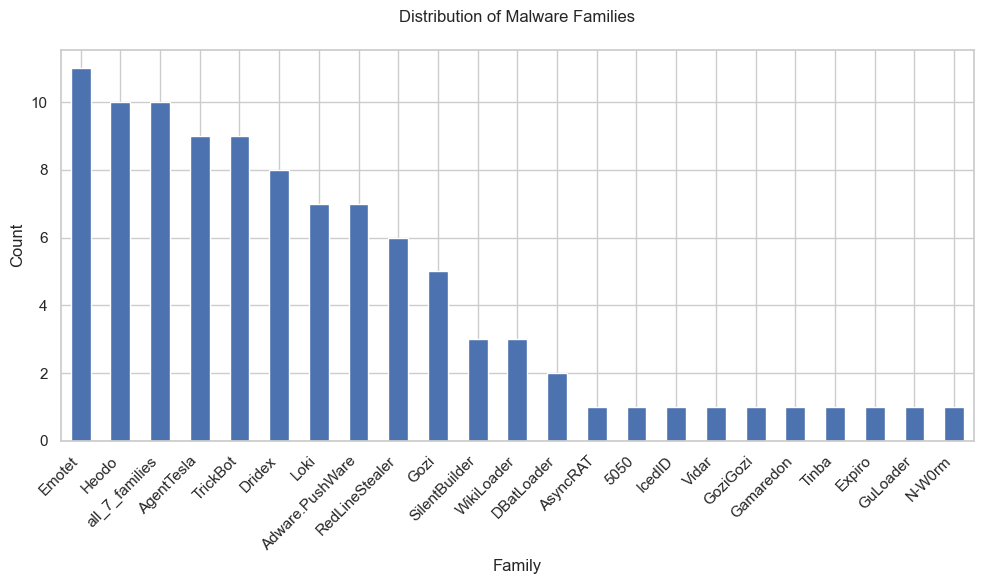

An error occurred: zero-size array to reduction operation fmin which has no identity

Debug information:
DataFrame shape: (100, 22)

Column data types:
hash                               object
family                             object
source                             object
status                             object
detection_ratio                    object
first_seen                 datetime64[ns]
last_seen                           int64
processes_count                     int64
files_written_count                 int64
files_deleted_count                 int64
registry_keys_set_count             int64
dns_lookups_count                   int64
ip_connections_count                int64
http_requests_count                 int64
mutexes_count                       int64
mitre_techniques_count              int64
mitre_techniques                   object
collected_date                     object
mitre_list                         object
detected                          float64
total   

<Figure size 1500x800 with 0 Axes>

In [196]:
# Now let's create the visualizations with proper error handling
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

try:
    # 1. Family Distribution
    if 'family' in df.columns:
        plt.figure(figsize=(10, 6))
        df['family'].value_counts().plot(kind='bar')
        plt.title('Distribution of Malware Families')
        plt.xlabel('Family')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # 2. MITRE Techniques Analysis
    if 'mitre_techniques' in df.columns:
        # Prepare MITRE data
        df['mitre_list'] = df['mitre_techniques'].fillna('').astype(str)
        df['mitre_list'] = df['mitre_list'].apply(lambda x: [t.strip() for t in x.split(',') if t.strip()])
        
        # Get all unique techniques
        all_techniques = []
        for techs in df['mitre_list']:
            all_techniques.extend(techs)
        
        if all_techniques:
            # Get top techniques
            top_techniques = Counter(all_techniques).most_common(10)
            
            # Plot top techniques
            plt.figure(figsize=(12, 6))
            techniques, counts = zip(*top_techniques)
            plt.bar(techniques, counts)
            plt.title('Top 10 MITRE ATT&CK Techniques')
            plt.xlabel('Technique')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            print("\nTop 10 MITRE techniques:")
            for tech, count in top_techniques:
                print(f"{tech}: {count}")
    
    # 3. Signature Analysis
    if 'signature_matches' in df.columns:
        # Prepare signature data
        df['signature_list'] = df['signature_matches'].fillna('').astype(str)
        df['signature_list'] = df['signature_list'].apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])
        
        # Get all signatures
        all_signatures = []
        for sigs in df['signature_list']:
            all_signatures.extend(sigs)
        
        if all_signatures:
            # Get top signatures
            top_signatures = Counter(all_signatures).most_common(10)
            
            # Plot top signatures
            plt.figure(figsize=(12, 6))
            signatures, counts = zip(*top_signatures)
            plt.bar(signatures, counts)
            plt.title('Top 10 Signature Matches')
            plt.xlabel('Signature')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            print("\nTop 10 signatures:")
            for sig, count in top_signatures:
                print(f"{sig}: {count}")
    
    # 4. Cross Analysis: MITRE Techniques vs Families
    if all(col in df.columns for col in ['mitre_techniques', 'family']):
        # Prepare the data
        technique_family_matrix = {}
        for idx, row in df.iterrows():
            family = row['family']
            if family not in technique_family_matrix:
                technique_family_matrix[family] = Counter()
            
            if isinstance(row['mitre_list'], list):
                technique_family_matrix[family].update(row['mitre_list'])
        
        if technique_family_matrix:
            # Get top 10 techniques overall
            all_techs = Counter()
            for family_techs in technique_family_matrix.values():
                all_techs.update(family_techs)
            top_techs = [tech for tech, _ in all_techs.most_common(10)]
            
            # Create matrix for heatmap
            matrix_data = pd.DataFrame(0, 
                                     index=technique_family_matrix.keys(),
                                     columns=top_techs)
            
            for family, techs in technique_family_matrix.items():
                for tech in top_techs:
                    matrix_data.loc[family, tech] = techs[tech]
            
            # Plot heatmap
            plt.figure(figsize=(15, 8))
            sns.heatmap(matrix_data, cmap='YlOrRd', annot=True, fmt='g')
            plt.title('Top MITRE Techniques by Malware Family')
            plt.xlabel('MITRE Technique')
            plt.ylabel('Malware Family')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("\nDebug information:")
    print("DataFrame shape:", df.shape)
    print("\nColumn data types:")
    print(df.dtypes)